In [50]:
from skimage import feature
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import os
from scipy.stats import chisquare

## TEXTURE COMPARAISON

In [51]:
ref_path = os.path.join ("photos",'ref')
test_path = os.path.join ("photos",'test')
bois_ref = [cv2.imread(os.path.join(ref_path,"ref_bois.jpg")),0]
gazon_ref = [cv2.imread(os.path.join(ref_path,"ref_gazon.jpg")),1]

test_image = [[cv2.imread(os.path.join(test_path,im)),0] if "bois" in im else [cv2.imread(os.path.join(test_path,im)),1] for im in os.listdir(test_path) ] 




In [52]:
#Preprocessing
width,heigth = 150,150
bois_ref[0] = cv2.resize(bois_ref[0],(width,heigth))
bois_ref[0] = cv2.cvtColor(bois_ref[0], cv2.COLOR_RGBA2GRAY)

gazon_ref[0] = cv2.resize(gazon_ref[0],(width,heigth))
gazon_ref[0] = cv2.cvtColor(gazon_ref[0], cv2.COLOR_RGBA2GRAY)

for test in test_image:
    test[0] = cv2.resize(test[0],(width,heigth))
    test[0] = cv2.cvtColor(test[0], cv2.COLOR_RGBA2GRAY)

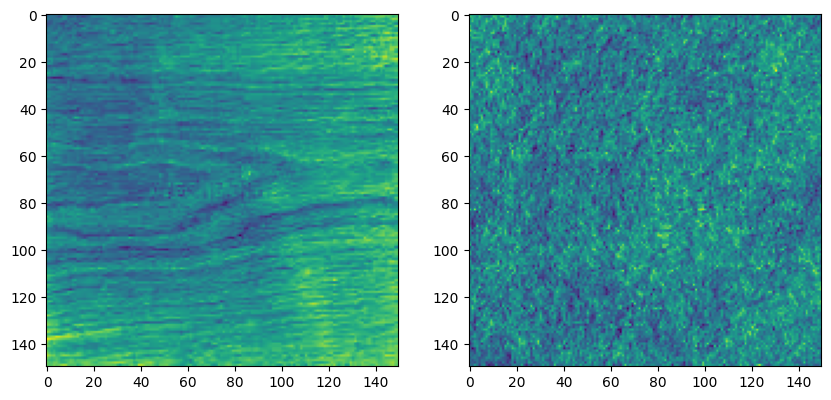

In [53]:
fig , ax = plt.subplots(1,2,figsize = (10,10))
ax[0].imshow(bois_ref[0])
ax[1].imshow(gazon_ref[0])


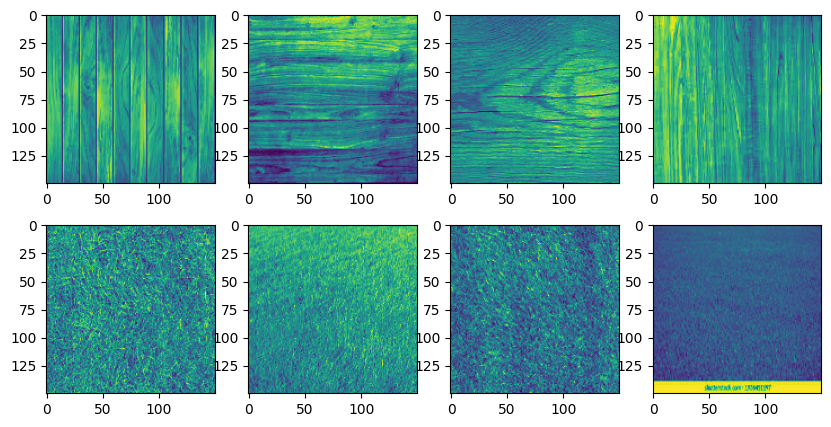

In [54]:
fig , ax = plt.subplots(2,4,figsize = (10,5))
k = 0
for i in range(0,2):
    for j in range(0,4):
        ax[i][j].imshow(test_image[k][0])
        k+=1

In [55]:
def match(ref , img,R,P,Method):
    lbp_ref = feature.local_binary_pattern(ref , P, R, Method)
    n_bins = int(lbp_ref.max() + 1)
    hist_ref, _ = np.histogram(lbp_ref, density=True, bins=n_bins, range=(0, n_bins))
    lbp_img = feature.local_binary_pattern(img , P, R, Method)
    hist_img, _ = np.histogram(lbp_img, density=True, bins=n_bins,range=(0, n_bins))
    score = chisquare(hist_ref,hist_img)
    return score.statistic


In [56]:
# def match(ref , img,R,P,Method):
#     lbp_ref = feature.local_binary_pattern(ref , P, R, Method)
#     n_bins = int(lbp_ref.max() + 1)
#     hist_ref, _ = np.histogram(lbp_ref, density=True, bins=n_bins, range=(0, n_bins))
#     lbp_img = feature.local_binary_pattern(img , P, R, Method)
#     hist_img, _ = np.histogram(lbp_img, density=True, bins=n_bins,range=(0, n_bins))
#     print(hist_img)
#     score = cv2.compareHist(hist_ref,hist_img,cv2.HISTCMP_CHISQR)
#     return score


In [66]:
#setting the lbp
R = 1
P = 8
threshold = 0.1
Method = "uniform"

for im in test_image:
    score = match(bois_ref[0],im[0],R,P,Method)
    res = 0 if score < threshold else 1
    print(score,res,im[1])

0.09578251678269886 0 0
0.022306764374442716 0 0
0.017379926811492453 0 0
0.24821250069096432 1 0
0.24635066236359557 1 1
0.17713189366361626 1 1
0.16587354842557428 1 1
0.08520730771532843 0 1


In [58]:
for im in test_image:
    score = match(gazon_ref[0],im[0],R,P,Method)
    res = 1 if score < threshold else 0
    print(score,res,im[1])

0.5759411799096231 0 0
0.1756284034293609 0 0
0.11495226760425639 0 0
0.9441784786785795 0 0
0.006091242740244418 1 1
0.005956247013032999 1 1
0.00211357057349109 1 1
0.03337813470983255 1 1


### FACE REGOGNITION

In [59]:
train_path = os.path.join("photos","0216221307.jpg")
train_image = cv2.imread(train_path)

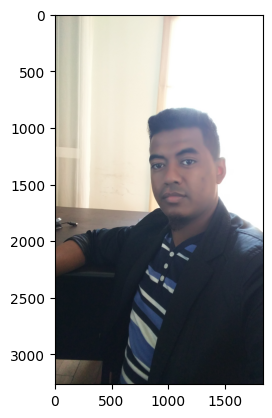

In [60]:
plt.imshow(train_image[:,:,::-1])

In [61]:
#preprocessing
train_image = train_image[700:1900,800:1600,:]
train_image = cv2.cvtColor(train_image,cv2.COLOR_BGR2GRAY)
width,heigth = 500,500
train_image = cv2.resize(train_image,(width,heigth))
# plt.imshow(train_image,cmap = "gray")

In [62]:
#model
model = cv2.face.LBPHFaceRecognizer_create()
model.train([train_image], np.array([1]))

In [63]:
#face detector
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
def detect_face(img):
    detected_faces = faceCascade.detectMultiScale(img, 1.01, 4)
    boxes = [(x ,y, w, h) for x, y, w, h in  detected_faces] #focus on the 1st face in the image

    # imgs = img[y:y+h, x:x+w] #focus on the detected area
    imgs = [img[box[1]:box[1]+box[3], box[0]:box[0]+box[2]] for box in boxes]
    imgs = [cv2.resize(img, (width, heigth)) for img in imgs]
    imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in imgs]

    # return imgs,boxes
    return imgs,boxes

In [67]:
# orange_color = (0,140,255)
yellow_color = (0,215,255)
# red_color = (0,0,255)
font = cv2.FONT_HERSHEY_SIMPLEX
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    rows,cols,sh = frame.shape
    #car ma camera est a l'envers
    M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),180,1)
    frame = cv2.warpAffine(frame,M,(cols,rows))
    imgs,boxes = detect_face(frame)
    if len(imgs) != 0:
        for im , box in zip(imgs,boxes):
            idx, confidence = model.predict(im)
            if confidence > 120 :
                cv2.putText(frame, 'ARIMINO', (box[0]-10, box[1]-10), font, 0.8,yellow_color, 2, cv2.LINE_AA)
                cv2.rectangle(frame,(box[0],box[1]),(box[0]+box[2],box[1]+box[3]),yellow_color,3)
                cv2.imshow("Frame",frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break